# Fake News Detection -- Natural Language Processing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.preprocessing import sequence
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

In [2]:
true = pd.read_csv(r"C:\Users\Bhawna\Downloads\True (1).csv")
false = pd.read_csv(r"C:\Users\Bhawna\Downloads\Fake (1).csv")

In [3]:
true['category'] = 1
false['category'] = 0
df = pd.concat([true, false])

In [4]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def clean_text(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'http\S+', '',text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = ' '.join(final_text)

    if not cleaned_text:
        cleaned_text = 'placeholder'
    return cleaned_text
df['clean_text'] = df['text'].apply(clean_text)

In [9]:
df.head()

,title,text,subject,date,category,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON (Reuters) head conservative Republi...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON (Reuters) Transgender people allowe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON (Reuters) special counsel investiga...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON (Reuters) Trump campaign adviser Ge...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLE/WASHINGTON (Reuters) President Donald ...


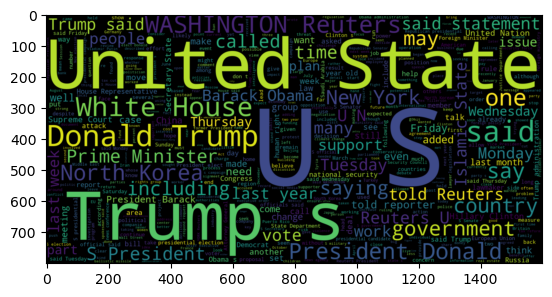

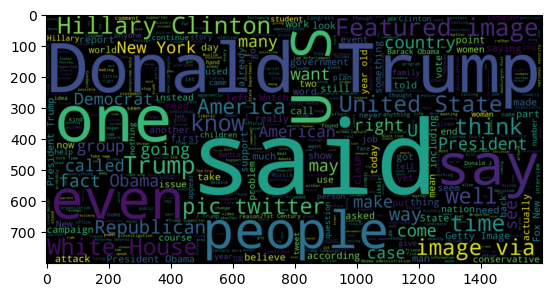

In [10]:
def plot_wordcloud(category):
    wc = WordCloud( width=1600,
    height=800,max_words=500, stopwords=STOPWORDS).generate(' '.join(df[df.category == category].clean_text))
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

plot_wordcloud(1)

plot_wordcloud(0)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.category, random_state=0)

In [12]:
x_train.shape

(33673,)

In [13]:
max_features = 10000
maxlen = 300
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [14]:
x_train.shape

(33673, 300)

In [16]:
x_train[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 3666,   23, 2358,  580,  612, 1943,   25, 2089,  683,
       3666, 2814, 4131,  161, 2573, 4260,  369,  115,  241, 5192,   96,
       2240,  283, 7387,  300,  265, 1105,  106, 9827, 1491,  462, 9503,
       8304,    9, 2199, 7038, 5116, 5512, 5192,   96,  577,  143, 1504,
       1811,  300, 8170,  309, 1155, 2066, 9503, 2744,  241, 6442,  343,
        268,  438,  404,  456, 3666, 2632,   40, 6823, 2573,  947,   25,
       3833, 4743, 4339, 5250,  244,   46,  565, 5669, 3566, 3292, 7931,
         87, 3069,  583, 5380, 1213, 4704,  376,    7,  100, 1058, 1902,
       4567, 2821,  791,  193,  389, 1092,  483,  100, 4424, 2240,  457,
         83, 1615,  142, 3959,  169, 1615,  655,  5

In [18]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Step 11: Load pre-trained GloVe embeddings
EMBEDDING_FILE = r"C:\Users\Bhawna\Downloads\glove.twitter.27B.100d.txt"

def load_embeddings(embedding_file, word_index, max_features):
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf-8'))
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, embed_size

embedding_matrix, embed_size = load_embeddings(EMBEDDING_FILE, tokenizer.word_index, max_features)

In [21]:
batch_size = 256
epochs = 1
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1, min_lr=0.00001)

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.25, dropout=0.25))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


132/132 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8106 - loss: 0.4147 - val_accuracy: 0.9674 - val_loss: 0.1018 - learning_rate: 0.0010


In [22]:
print('Accuracy on Training data: ', model.evaluate(x_train, y_train)[1]*100, '%')
print('Accuracy on Test data: ', model.evaluate(x_test, y_test)[1]*100, '%')

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 65s 61ms/step - accuracy: 0.9684 - loss: 0.0976
Accuracy on Training data:  96.81941270828247 %
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9653 - loss: 0.1062
Accuracy on Test data:  96.7394232749939 %


In [23]:
model.save('fake_news_weights.h5')
print('Model saved')

Model saved


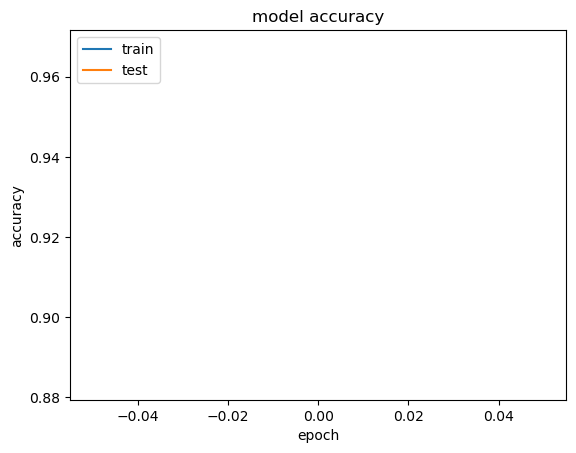

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

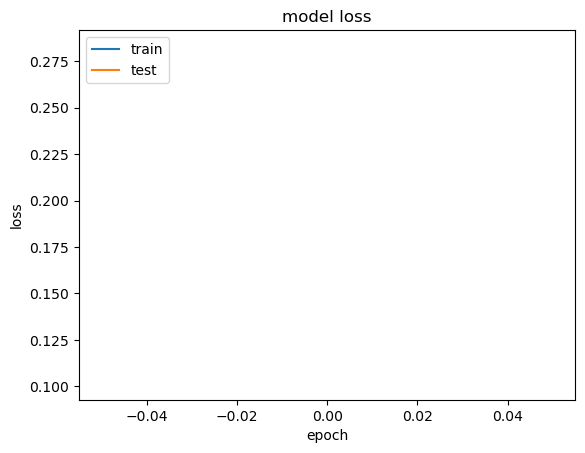

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
pred_probablities = model.predict(x_test)
pred = (pred_probablities > 0.5).astype('int32')

print(classification_report(y_test, pred, target_names=['Fake', 'Not Fake']))

351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step
              precision    recall  f1-score   support

        Fake       0.98      0.96      0.97      5858
    Not Fake       0.95      0.98      0.97      5367

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



In [30]:
cm = confusion_matrix(y_test, pred)
cm = pd.DataFrame(cm, index=['fake', 'original'], columns=['Fake','Original'])

In [31]:
print(cm)

          Fake  Original
fake      5603       255
original   111      5256
